In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib inline
# import cartopy

In [2]:
def get_Ag(fn):
    df = nc.Dataset(fn)

    re_name = "re_fcoeffs"
    im_name = "im_fcoeffs"

    real = df.variables[re_name][:].transpose(0,2,1)
    imag = df.variables[im_name][:].transpose(0,2,1)

    wlat = df.variables['wavelength_lat'][:]
    wlon = df.variables['wavelength_lon'][:]
    # wlat = 0.00833
    # wlon = 0.00833

    df.close()
    
    ncells = real.shape[0]

    AE = 6371.0008 * 1E3 # Earth's radius in [m]

    wla = wlat * AE
    wlo = wlon * AE

    hhg = real + 1.0j * imag

    # print(hhg[0:10])

    N = 0.02 # s^{-1}
    U = 10.0 # m s^{-1}
    V = 10.0 # m s^{-1}

    kk = np.arange(0,12)
    ll = np.arange(-6,6)

    # print(kk, ll)
    kkg, llg = np.meshgrid(kk,ll)
    
    # print(kkg.shape, llg.shape)

    kkg = np.expand_dims(kkg,0)
    llg = np.expand_dims(llg,0)
    wla = np.expand_dims(wla,1)
    wlo = np.expand_dims(wlo,1)
    wla = np.expand_dims(wla,1)
    wlo = np.expand_dims(wlo,1)
    
    # print(kkg.shape, llg.shape)
    # print(wla.shape, wlo.shape)

    # kkg = np.dot(1.0 / wlo, kkg)
    kkg = np.repeat(kkg, ncells, axis=0) / wlo
    llg = np.repeat(llg, ncells, axis=0) / wla

    # print(kkg.shape, llg.shape)
    # print(kkg**2 + llg**2)

    omg_grid_sq = (- kkg * U - llg * V)**2
    # print(omg_grid_sq)
    mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))

    h2 = hhg * np.conj(hhg)
    # if 'full' in fn:
    #     h2 /= (275**2)
    Ag = 0.5 * ( h2 * N**2 / np.sqrt(omg_grid_sq) ) #* 1e-12
    cgz = N * kkg * mmg / (kkg**2 + mmg**2)**(3/2)
    
    Ag = np.real(Ag) * kkg * cgz
    Ag = Ag.sum(axis=(1,2))
    # Ag[np.where(Ag==np.nan)] = 0.0
    Ag = Ag.filled(np.nan)
    # Ag[np.ma.masked_invalid(Ag)] = np.nan
    # print(Ag.shape)

    
    # print(mmg)

    # print(Ag[100:200])
    return Ag

In [3]:
def remove_high_lats(arr, lats, lat_trunc=80):
    arr = arr[np.where(lats < lat_trunc)]
    return arr


In [4]:
sfx = '0010'

fn_norot = '../data/output_full_spec_%s.nc' %sfx
Ag_norot = get_Ag(fn_norot)
# Ag_norot *= 1e-9

fn_rot = '../data/output_axial_norot_%s.nc' %sfx
Ag_rot = get_Ag(fn_rot)

df = nc.Dataset('../data/icon_grid_%s_R02B04_G_linked.nc' %sfx)

clat = df.variables['lat_cell_centre'][:]
clon = df.variables['lon_cell_centre'][:]
# clat_vertices = df.variables['clat_vertices'][:]
# clon_vertices = df.variables['clon_vertices'][:]
# links = df.variables['links'][:]

lats = np.rad2deg(clat)
lons = np.rad2deg(clon)

df.close()

# Ag_norot = remove_high_lats(Ag_norot, lats)
# Ag_rot = remove_high_lats(Ag_rot, lats)
# lons = remove_high_lats(lons, lats)
# lats = remove_high_lats(lats, lats)

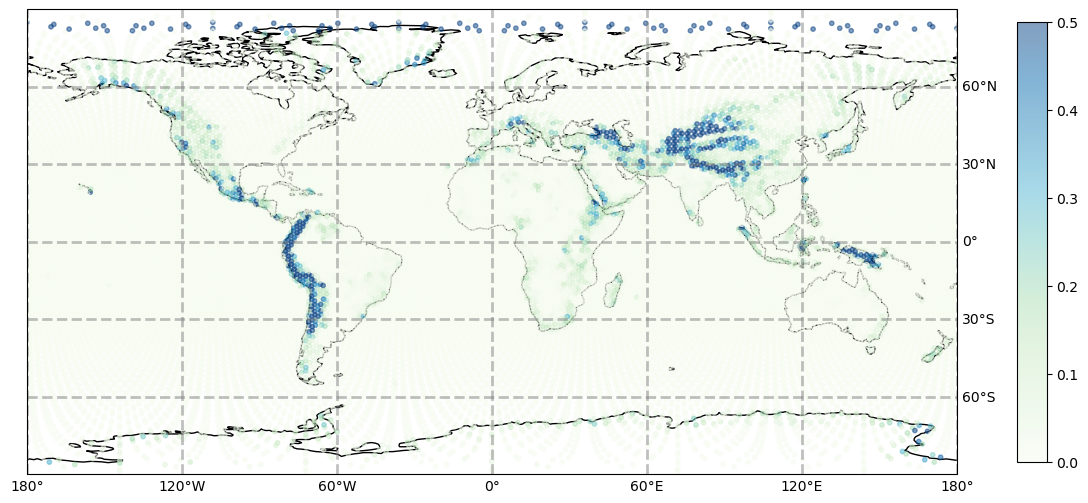

In [22]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

# fig = plt.figure(figsize=(16, 12))
# ax1 = fig.add_subplot(211)
# im1 = ax1.scatter(x=lons, y=lats,
#             s=0.5,
#             c=Ag_norot,
#             alpha=0.5,
#             transform=ccrs.PlateCarree(),
#             norm=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')

# ax2 = fig.add_subplot(212)
# im2 = ax2.scatter(x=lons, y=lats,
#             s=0.5,
#             c=Ag_norot,
#             alpha=0.5,
#             transform=ccrs.PlateCarree(),
#             norm=None)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')

vmin = 0.0
vmax = 0.5
n_points = 30

# fig = plt.figure(figsize=(12,8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# Ag_norot = np.ma.masked_invalid(Ag_norot)
# # Ag_norot *= 1.0 / 600
# # Ag_norot = Ag_norot.filled(-999)

# levels = np.linspace(vmin, vmax, n_points)
# # im = ax.tricontourf(lons,lats,Ag_norot, transform=ccrs.PlateCarree(), levels=levels)

# ax.coastlines()
# im = ax.scatter(x=lons, y=lats,
#             # color="dodgerblue",
#             s=10.0,
#             c=Ag_norot,
#             alpha=0.5,
#             transform=ccrs.PlateCarree(),
#             norm=None,
#             cmap='bwr',
#             vmin = -vmax * 10e8,
#             vmax = vmax * 10e8
#             )
# ax.set_global()
# ax.set_title("full spectrum")

# cax = fig.add_axes([0.95, 0.22, 0.025, 0.55])
# fig.colorbar(im, cax=cax)

# plt.show()



fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.tricontour(lons,lats,Ag,80, transform=ccrs.PlateCarree())
ax.coastlines()
im = ax.scatter(x=lons, y=lats,
            # color="dodgerblue",
            s=10.0,
            c=Ag_rot,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            norm=None,
            cmap='GnBu',
            vmin = 0,
            vmax = 0.5
            )
ax.set_global()

# ax.set_title("axial")

# cax = fig.add_axes([0.91, 0.22, 0.025, 0.55])
cax = fig.add_axes([0.95, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False


gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter(auto_hide=False)
gl.yformatter = LatitudeFormatter()

ax.tick_params(axis="both",
               tickdir='out',
               length=15,
               grid_transform=ccrs.PlateCarree())

plt.savefig("img/wad.pdf")
plt.show()

# diff = np.abs(Ag_norot - Ag_rot)# / Ag_norot
# diff[np.where(diff < 1e1)] = np.nan

# fig = plt.figure(figsize=(12,8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# # ax.tricontour(lons,lats,Ag,80, transform=ccrs.PlateCarree())
# ax.coastlines()
# im = ax.scatter(x=lons, y=lats,
#             # color="dodgerblue",
#             s=10.0,
#             c=diff,
#             alpha=0.5,
#             transform=ccrs.PlateCarree(),
#             norm=None,
#             cmap='Reds',
#             vmax=vmax)
# ax.set_global()

# ax.set_title("difference: | full(no rotation) - axial(optimal rotation) |")

# cax = fig.add_axes([0.91, 0.22, 0.025, 0.55])
# fig.colorbar(im, cax=cax)
# plt.show()

In [50]:
sfx = '0010'
df = nc.Dataset('../data/icon_grid_%s_R02B04_G_linked.nc' %sfx)

clat = df.variables['lat_cell_centre'][:]
clon = df.variables['lon_cell_centre'][:]

lats = np.rad2deg(clat)
lons = np.rad2deg(clon)

df.close()

print(np.deg2rad(28))

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

vmin = 0.0
vmax = 0.5
n_points = 30

idx = np.where(np.abs(lats - 28) < 1e-1)
print(idx)
print(lats[idx[0]])
print(Ag_rot[idx[0]])

0.4886921905584123
(array([  343,  1021,  1367,  2045,  2391,  3069,  3415,  4093,  4439,
        5117,  5588,  5603,  5985,  6012,  6612,  6627,  7009,  7036,
        7636,  7651,  8033,  8060,  8660,  8675,  9057,  9084,  9684,
        9699, 10081, 10108]),)
[28.027799514911518 28.027799514911678 28.02779951491166
 28.027799514911305 28.027799514911734 28.027799514911486
 28.027799514911464 28.02779951491147 28.027799514911635
 28.027799514911354 27.94775830699332 28.02134078042272 28.02134078042289
 27.947758306993332 27.94775830699321 28.021340780422864 28.02134078042243
 27.947758306993485 27.947758306993546 28.021340780422562
 28.02134078042273 27.94775830699345 27.947758306993578 28.02134078042267
 28.021340780423085 27.947758306993375 27.947758306993517
 28.02134078042263 28.02134078042252 27.94775830699341]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


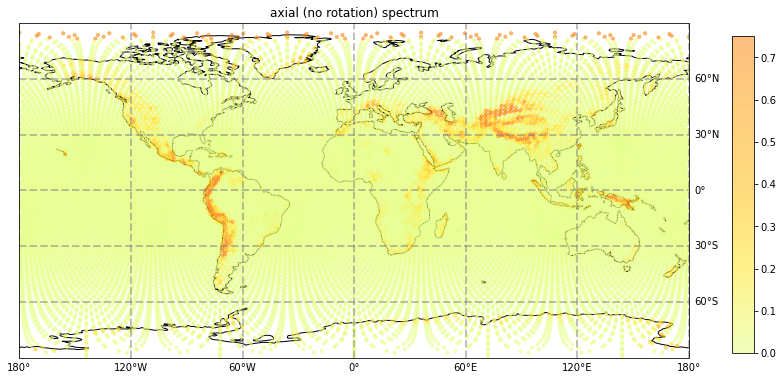

In [112]:
df = nc.Dataset('../data/icon_grid_%s_R02B04_G_linked.nc' %sfx)

clat = df.variables['lat_cell_centre'][:]
clon = df.variables['lon_cell_centre'][:]

lats = np.rad2deg(clat)
lons = np.rad2deg(clon)

df.close()

sfx = '0010'
fn_norot = '../data/output_axial_norot_%s.nc' %sfx
Ag_norot = get_Ag(fn_norot)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

Ag_norot = np.ma.masked_invalid(Ag_norot)

Ag_norot = remove_high_lats(Ag_norot, lats, lat_trunc=85)
lons = remove_high_lats(lons, lats, lat_trunc=85)
lats = remove_high_lats(lats, lats, lat_trunc=85)

vmin = 0.0
vmax = 0.75
n_points = 30

levels = np.linspace(vmin, vmax, n_points)
# im = ax.tricontourf(lons,lats,Ag_norot, transform=ccrs.PlateCarree(), levels=levels, extend='max', alpha=0.8)

ax.coastlines()
im = ax.scatter(x=lons, y=lats,
            # color="dodgerblue",
            s=10.0,
            c=Ag_norot,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            norm=None,
            cmap='Wistia',
            vmax=vmax)
ax.set_global()
ax.set_title("axial (no rotation) spectrum")

cax = fig.add_axes([0.95, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False


gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter(auto_hide=False)
gl.yformatter = LatitudeFormatter()

ax.tick_params(axis="both",
               tickdir='out',
               length=15,
               grid_transform=ccrs.PlateCarree())

plt.show()

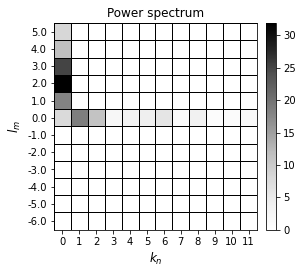

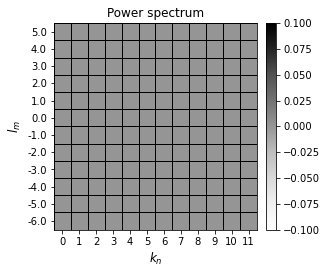

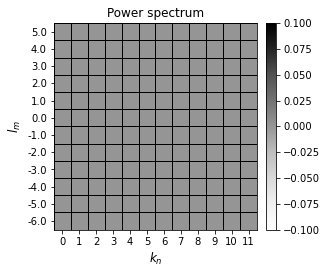

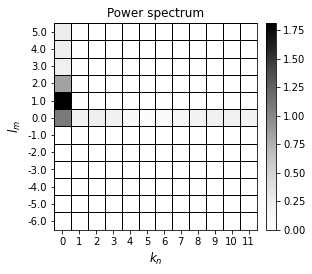

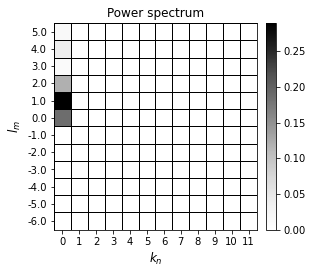

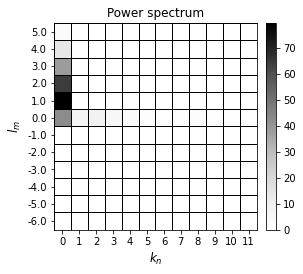

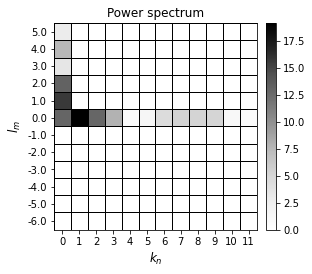

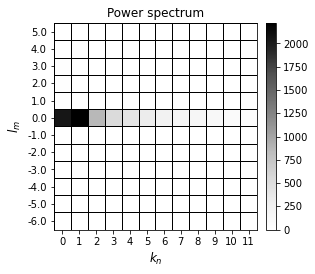

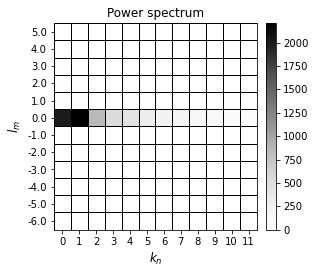

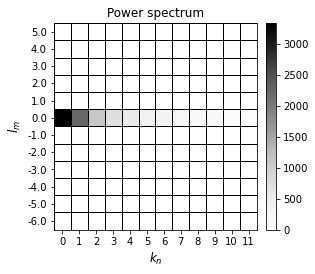

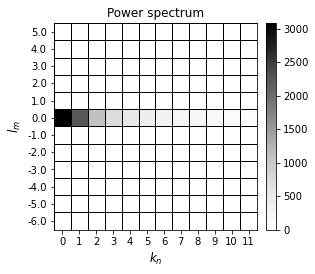

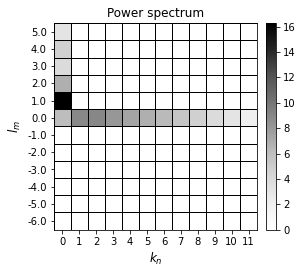

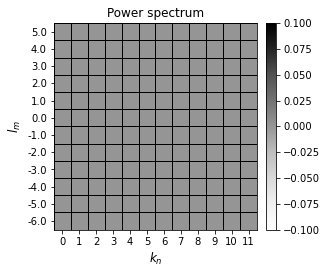

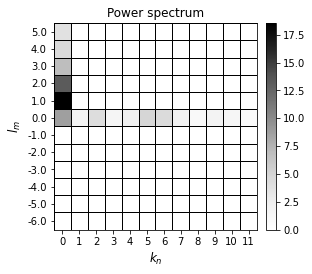

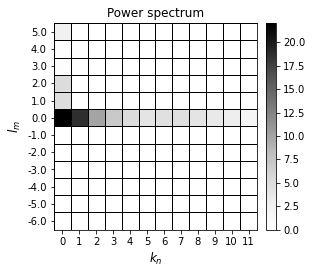

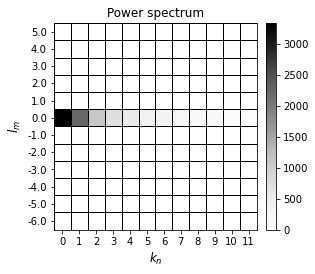

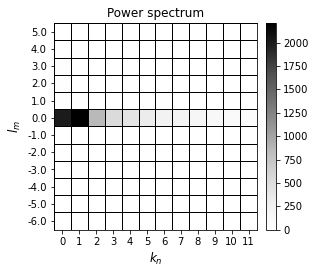

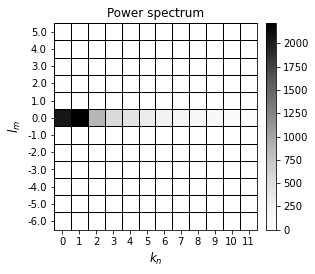

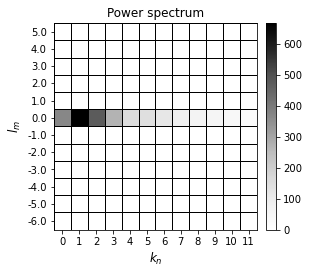

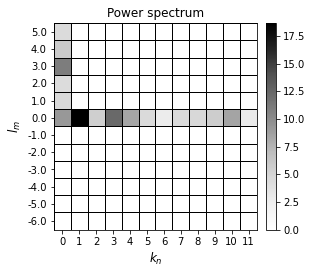

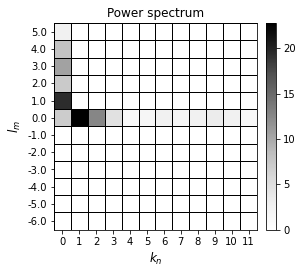

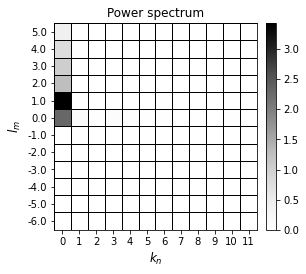

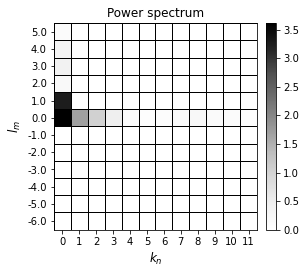

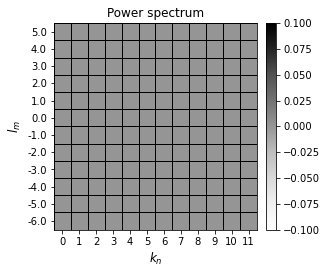

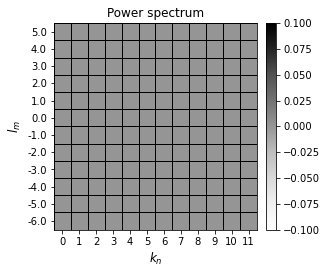

In [117]:
sfx = '0010'

fn = '../data/output_full_spec_%s.nc' %sfx
fn = '../data/output_axial_norot_%s.nc' %sfx
df = nc.Dataset(fn)

re_name = "re_fcoeffs"
im_name = "im_fcoeffs"

real = df.variables[re_name][:].transpose(0,1,2)
imag = df.variables[im_name][:].transpose(0,1,2)

df.close()

for i in range(30,55):

    idx = i
    
    fcoeffs = real[idx] + 1.0j * imag[idx]
    
    fs = (4,3.8)
    plt.figure(figsize=fs)

    im = plt.pcolormesh(np.abs(fcoeffs), edgecolors='k', cmap='Greys')
    plt.colorbar(im,fraction=0.05, pad=0.04)
    nhar_j = 12
    if nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2,nhar_j/2)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)

    ylocs = np.arange(.5,12.5,1.0)
    plt.yticks(ylocs, m_j)
    plt.xticks(ylocs, np.arange(0,12))
    plt.title("Power spectrum")
    plt.xlabel(r'$k_n$', fontsize=12)
    plt.ylabel(r'$l_m$', fontsize=12)
    # plt.grid()
    # plt.savefig('axial_coeffs_rot.pdf', bbox_inches='tight')
    plt.show()
